# Initialization and Activation Units: A Numerical Stability's Perspective

This assignment will use the following external packages: pytorch == 1.6.0


*** Although we use PyTorch intensively in this coding problem, students don't need to touch PyTorch codes.***

*** They only needs to deal with NumPy codes ***

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn

## (a) Floating-point representations of real numbers

Mathematically, our models are typically represented by real numbers with infinite precision. However, when programming, it is inevtiable that we can only use representations with limited precision. For example, our data are usually stored as floating-point numbers. This short question requires you to recall such basic concepts in computer science. Please read the following codes and answer the followinng questions in your comments.

1. Why ``print(a)`` shows ``0.0``? Why ``print(b)`` shows ``inf``?

2. Why ``print(c)`` and ``print(d)`` can give you the correct values, but ``print(c + d - d)``, ``print(c * c)`` or ``print(d * d)`` cannot?


In [2]:

a = 1e-10000
print(a)

b = 1e+10000
print(b)



0.0
inf


In [3]:
c = 1e-250
print(c)

d = 1e+250
print(d)

print(c + d - d)
print(c * c)
print(d * d)

1e-250
1e+250
0.0
0.0
inf


### start (a)

<font color='blue'>

1. ``print(a)`` shows ``0`` because of underflow of float numbers while ``print(b)`` shows ``inf`` because of overflow.

2. Due to the rounding process of floating-point arithmetic, ``c + d`` will round the mantissa of ``c`` to ``0`` and the result of ``c + d`` is exactly the same as ``d`` in binary. So ``c + d - d`` will give you ``0``. Similar to 1, evaluating ``c * c`` or ``d * d`` will cause underflow or overflow.

</font>

### end (a)

## (c) Gradient vanishing and exploding - Theory 2

This part aims to give students some intuitions on on numerical issues we talked about in previous parts. Also, it helps you verify you answers in previous parts because you can try different experiments to examine the formula you get.


Without loss of generality, we use **normal distribution with zero mean for all random varibales**. Also, for all internal layers ($l \neq 0, l \neq L$), we assume that $ n^{(l-1)} =  n^{(l)} = N$, $ F_{ \mathbf{W}^{(l-1)} } = F_{ \mathbf{W}^{(l)} }$ (their weights have the same distribution), and  $ F_{ (\sigma')^{(l-1)} } = F_{ (\sigma')^{(l)} }$ (those diagnoal matrices have the same distribution). In the code, the last assumption is acchieved by make $ z_{i}^{(l)}$ has the same distribution. For boundary conditions, we assume $n^{(0)} = n^{(L)} = 1$, you can imagine that we are trying to fit a $1$-D function.


The following function is designed to sample a concrete $ \nabla_{ \mathbf{W}^{(l)} } L $ using the normal distribution assumption. The input arguments are `gamma_s_prime` ($\gamma_{\sigma'}$), `gamma_w` ($ \gamma_{W} $), `gamma_nabla_y` ($ \gamma_{\nabla_{y} L} $), and `gamma_a` ($ \gamma_{a} $),.
It means that,

$$ \sigma' ( z_{i}^{(l)} ) \sim \mathcal{N} (0, \gamma_{\sigma'}^2 ) $$

$$ W_{ij}^{(l)} \sim \mathcal{N} (0, \gamma_{W}^2 ) $$

$$ \nabla_{y} L [i] \sim \mathcal{N} (0, \gamma_{\nabla_{y} L}^2 ) $$

$$ a^{(l)}_{i} \sim \mathcal{N} (0, \gamma_{a}^2 ) $$

For  meanings of these symbols, please review part (b). Then, **please fill the codes in the `grad_wrt_weight` function**. You may need to review part(b)'s formulas.

In [4]:
# calculate the gradient of loss w.r.t. the the l-th layer's weight
def grad_wrt_weight(gamma_s_prime, gamma_w, gamma_nabla_y, gamma_a, L, l, N, activation="tanh"):
    assert (gamma_nabla_y > 0), ValueError
    assert (gamma_s_prime > 0), ValueError
    assert (gamma_w > 0), ValueError
    assert (L > 2), ValueError
    assert (l > 1), ValueError("Don't use the firt layer!")
    assert (l < L), ValueError("Don't use the last layer!")
    assert (N > 1), ValueError

    # for the last layer
    delta = gamma_nabla_y * np.random.randn(N)

    for i in range(L, l, -1):
        # print(i)
        # sample a new couple of matrices for each iteration
        diag_s_prime = None
        W = None

        ### TODO:
        ### fill codes using the backpropagation formula
        ### start c-1 ###
        s_prime = gamma_s_prime * np.random.randn(N)
        diag_s_prime = np.diag(s_prime)

        W = gamma_w * np.random.randn(N, N)
        ### end c-1 ###

        delta =  W.T@ diag_s_prime @ delta

    s_prime = gamma_s_prime * np.random.randn(N)
    diag_s_prime = np.diag(s_prime)
    delta = diag_s_prime @ delta
    # print(delta.shape)

    a = gamma_a * np.random.randn(N)
    grad = np.outer(delta, a.T)
    # print(grad.shape)

    return(grad)



Now, the following codes will generate such gradient matrices and calculate the emperical variance of all the elements.

Here, we split the parameters and the estimation part to avoid run the estimation each time you change parameters.

In [5]:
### try to change parameters here 
L = 8
l = 2
N = 64
gamma_s_prime = 2.0
gamma_w = 2.0
gamma_nabla_y = 2.0
gamma_a = 2.0
###

# L = 64
# l = 2
# N = 128
# gamma_s_prime = 2.0
# gamma_w = 2048.0
# gamma_nabla_y = 2.0
# gamma_a = 2.0


# L = 64
# l = 2
# N = 128
# gamma_s_prime = 2.0
# gamma_w = 0.0001
# gamma_nabla_y = 2.0
# gamma_a = 2.0


In [6]:
repreat_n = 1000

# sample repreat_n times
nabla_w_list = []
for _ in range(repreat_n):
    nabla_w = grad_wrt_weight(gamma_s_prime=gamma_s_prime,
                              gamma_w=gamma_w,
                              gamma_nabla_y=gamma_nabla_y,
                              gamma_a=gamma_a,
                              L=L, l=l, N=N)
    nabla_w_list.append(nabla_w)

nabla_w_list = np.array(nabla_w_list)

flattened_nabla_w = nabla_w_list.reshape(-1)
empirical_variance = np.var(flattened_nabla_w)


print(empirical_variance)



7.432327655958521e+19


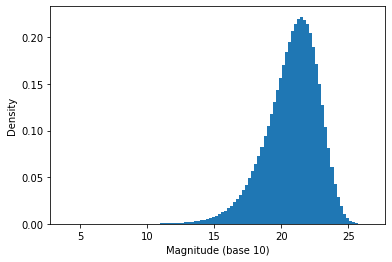

In [8]:

# visualization
magnitude = np.log(np.abs(flattened_nabla_w))
plt.hist(magnitude, bins=100, density=True)
plt.xlabel("Magnitude (base 10)")
plt.ylabel("Density")
plt.show()

The function below is the theoretical variance derived from part (b). Please **fill the codes**.

In [9]:
def get_theoretical_variance(gamma_s_prime, gamma_w, gamma_nabla_y, gamma_a, L, l, N):
    assert (gamma_nabla_y > 0), ValueError
    assert (gamma_s_prime > 0), ValueError
    assert (gamma_w > 0), ValueError
    assert (L > 2), ValueError
    assert (l > 1), ValueError("Don't use the firt layer!")
    assert (l < L), ValueError("Don't use the last layer!")
    assert (N > 1), ValueError

    variance = None
    ### TODO:
    ### fill codes here according to your results in the last part
    ### start c-2 ###
    variance = (
        np.power(float(N), (L - l)) *
        np.power(float(gamma_s_prime), 2 * (L - l + 1)) *
        np.power(float(gamma_w), 2 * (L - l)) *
        np.power(float(gamma_nabla_y), 2) * np.power(float(gamma_a), 2)
        )
    ### end c-2 ###
    return variance

You should see that your theoretical variance has the same magnitude with the empirical variance estimation by running the codes below.

In [10]:
theoretical_variance = get_theoretical_variance(gamma_s_prime=gamma_s_prime,
                                                gamma_w=gamma_w,
                                                gamma_nabla_y=gamma_nabla_y,
                                                gamma_a=gamma_a,
                                                L=L, l=l, N=N)
print(theoretical_variance)




7.378697629483821e+19


Now please change the parameters and answer the following questions.

(1) Increase the number of layers ($L$) to 64, increase $N$ to 256, increase `gamma_w` to 1024.0 and re-rerun the above program. What will happen? Why?

(2) Keep the parameters the same as (1), change `gamma_w` to 0.001 and and re-rerun the above program. What will happen? Why?

### start (c)-3
<font color='blue'>

(1) The empirical_variance becomes infinity (overflow). So as the theoretical_variance

(2) The empirical_variance becomes 0 (overflow). So as the theoretical_variance

</font>
### end (c)-3

## (d) Graident vanishing and exploding - Practice in PyTorch

From (a), we can have a rough sense that if our deep neural networks stack many layers with extremely small/large values, it is very possible to encounter numerical issues similar to (a) when using back-propagation to optimize our model. In this part, we will use concrete examples to show you that what will happen in real neural networks with non-linear activation units if we don't initialize the parameters appropriately.


How can we detect gradient vanishing? Here, we provide a helper function that can visualize the average of absolute values of gradients for each layer in the neural network. A simple rule is to check the magnitutes of gradients in the backward propagation path. If magnitudes of gradients decrease/increase drastically from the last layer to the first layer, it is very possible that we are encountered with a gradient vanishing/exploding.

In [10]:
def plot_grad_flow(named_parameters, label=""):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, colors="b" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient Absolute Value")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()


Now, please build a simple MLP consists of $L$ layers ($L \gt 2$) as described in this problem. For each internal layer ($1 \lt l \lt L$), $n^{(l)} = n^{l+1} = N$. `n_0` and `n_L` in the codes corresponds to $n^{(0)}$ and $n^{(L)}$. You may use `nn.Sequential` to build a layer with non-linear activation units.

Note:
We don't use bias terms here.

In [11]:

def create_mlp(L, N, n_0=2, n_L=1, activation="sigmoid"):
    assert (L > 2), ValueError

    input_layer = nn.Linear(n_0, N, bias=False)
    output_layer = nn.Linear(N, n_L, bias=False)

    layer_lists = []
    for i in range(L-2):
        # you should modify the internal_layer
        internal_layer = None
        if (activation == "tanh"):
            internal_layer = nn.Sequential(
                nn.Linear(N, N, bias=False),
                nn.Tanh()
            )
        elif (activation == "sigmoid"):
            internal_layer = nn.Sequential(
                nn.Linear(N, N, bias=False),
                nn.Sigmoid()
            )
        elif (activation == "relu"):
            internal_layer = nn.Sequential(
                nn.Linear(N, N, bias=False),
                nn.ReLU()
            )
        else:
            assert NotImplementedError

        layer_lists.append(internal_layer)

    layer_lists = [input_layer, ] + layer_lists + [output_layer, ]

    return(nn.Sequential(*layer_lists))


Although PyTorch often does a quite good initialization automatically when creating the model, in this part we require you to **implement different initialization using  NumPy** and **you cannot use other packages**. The following function is a wrapper. You need to implement `init_const`, `init_normal`, `init_xavier_normal`, `init_xavier_uniform`, `init_kaiming_normal` and 'init_kaiming_uniform' in the part and following parts.

In [12]:
def init_weights(m, mean=0.0, var=1.0, method="default"):
    if type(m) == nn.Linear:
        if (method == "default"):
            pass
        else:
            # this wrapper will handle the conversion
            # between PyTorch and NumPy
            m.weight.data.fill_(0)
            w = m.weight.detach().data.numpy()

            if (method == "const"):
                w = init_const(w, value=mean)
            elif (method == "normal"):
                w = init_normal(w, mean=mean, var=var)
            elif (method == "xavier_normal"):
                w = init_xavier_normal(w)
            elif (method == "xavier_uniform"):
                w = init_xavier_uniform(w)
            elif (method == "kaiming_normal"):
                w = init_kaiming_normal(w)
            elif (method == "kaiming_uniform"):
                w = init_kaiming_uniform(w)
            else:
                raise NotImplementedError

            with torch.no_grad():
                m.weight.data = torch.Tensor(w)
    else:
        # don't touch other layers
        pass

For this part, please implement `init_const` and `init_normal` in the following code block. `init_const` is constant initialization and fills the matrix with `value`. `init_normal` is normal distribution initialization and fills the matrix with random variables drawn from $\mathcal{N}(\mu, var)$.

In [13]:
def init_const(w, value):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ### TODO
    ### start d-1
    result = value * np.ones_like(w)
    ### end d-1
    return result


def init_normal(w, mean, var):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ### TODO
    ### start d-2
    result = mean + np.sqrt(var) * np.random.randn(*(w.shape))
    ### end d-2
    return result


You can check your implementations by printing out the weights like the following codes.

In [14]:
# demo
model = create_mlp(L=4, N=2, n_0=2, n_L=1, activation="sigmoid")

print("=" * 64)
print("before")
print("=" * 64)
print(model[0].weight)

for m in model.modules():
    init_weights(m, mean=1.0, method="const")

print("=" * 64)
print("after")
print("=" * 64)
print(model[0].weight)

before
Parameter containing:
tensor([[-0.3309, -0.1471],
        [-0.0884, -0.2879]], requires_grad=True)
after
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [15]:
# demo
model = create_mlp(L=4, N=2, n_0=2, n_L=1, activation="sigmoid")

print(model[0].weight)

for m in model.modules():
    init_weights(m, mean=1.0, var=1.0, method="normal")

print(model[0].weight)

Parameter containing:
tensor([[ 0.5849, -0.5071],
        [ 0.0253,  0.2109]], requires_grad=True)
Parameter containing:
tensor([[ 0.3657, -0.2645],
        [ 0.0832,  0.0425]], requires_grad=True)


Now, let us get started with training a real neural network!!!

In [16]:

def test(model, X, y):
    model.eval()
    y_pred = model(X)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(y_pred, y)
    return(loss.item())

def training(model, X, y, lr, optimizer="adam", epochs=100, log_interval=100, visual_debug=False):
    loss_train_his = []
    loss_fn = torch.nn.MSELoss()

    if (optimizer == "adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif (optimizer == "sgd"):
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise NotImplementedError

    for i in range(epochs):


        model.train()
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        loss_train = loss.item()
        loss_train_his.append(loss_train)

        loss.backward()


        if (i % log_interval == log_interval - 1):
            if visual_debug:
                plot_grad_flow(model.named_parameters(), label=str(i))
            print("epoch = {0:04d},  loss = ".format(i), loss_train)

        optimizer.step()


    print("training complete")
    return model, loss_train_his

In [17]:
# generating training daya
X_train = torch.arange(-1, 1, 0.1)
X_train_aug = torch.stack([X_train, torch.ones_like(X_train)], dim=1)
y_train = torch.sin(10 * X_train_aug[:, :1])


The following code cells are differnet initialization configurations. ** Run only one cell for each experiment and skip others.**

In [18]:
# # config 1
# model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="sigmoid")
# for m in model.modules():
#     init_weights(m, mean=0.0, method="const")

In [38]:
# # config 2
# model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="sigmoid")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=0.05, method="normal")

**Note: We changed the number of neurons in config 3**

In [44]:
# config 3
model = create_mlp(L=4, N=128, n_0=2, n_L=1, activation="sigmoid")
for m in model.modules():
    init_weights(m, mean=0.0, var=0.05, method="normal")

**Note: We changed the number of layers in config 4 !!!**

In [33]:
# # config 4
# # We changed the layer numbers here !!!
# model = create_mlp(L=32, N=128, n_0=2, n_L=1, activation="sigmoid")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=0.05, method="normal")

** Go back to config 3, now we only change the initial weights's variance. **

In [22]:
# # config 5
# model = create_mlp(L=4, N=128, n_0=2, n_L=1, activation="sigmoid")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=1024.0, method="normal")

The following codes will train the neural network, visualize the training loss and plot the fitted function.

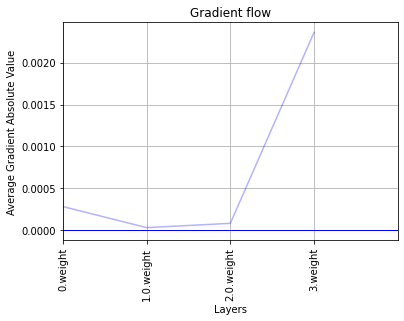

epoch = 0099,  loss =  0.4635448455810547


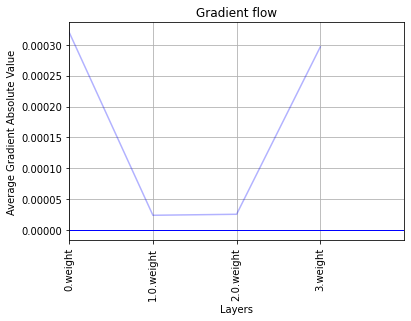

epoch = 0199,  loss =  0.45796307921409607


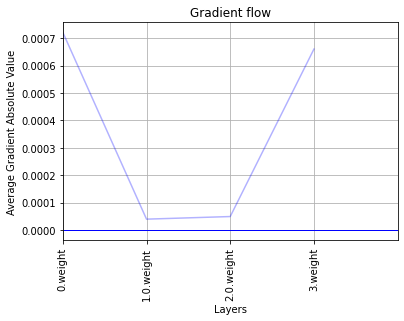

epoch = 0299,  loss =  0.43726983666419983


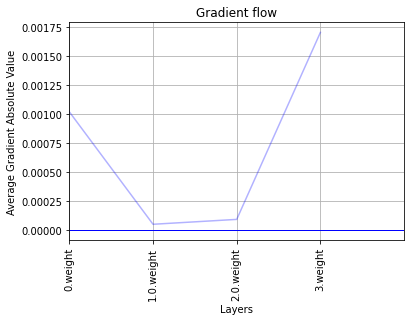

epoch = 0399,  loss =  0.36639636754989624


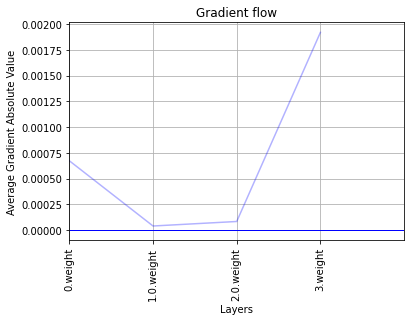

epoch = 0499,  loss =  0.2841991186141968


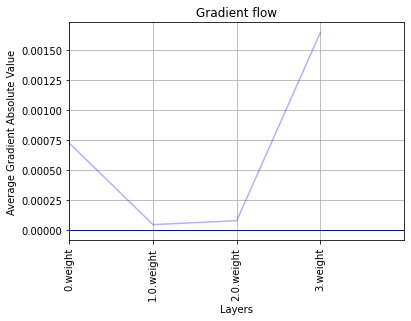

epoch = 0599,  loss =  0.21819019317626953


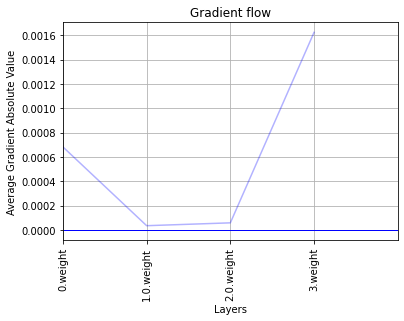

epoch = 0699,  loss =  0.13981880247592926


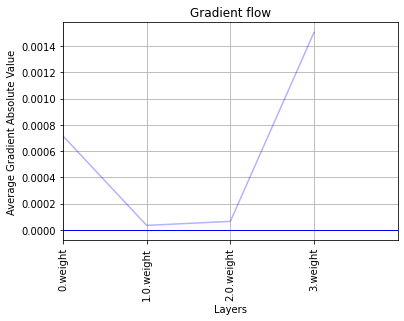

epoch = 0799,  loss =  0.07894521206617355


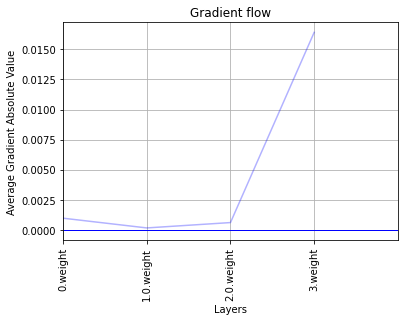

epoch = 0899,  loss =  0.006675733719021082


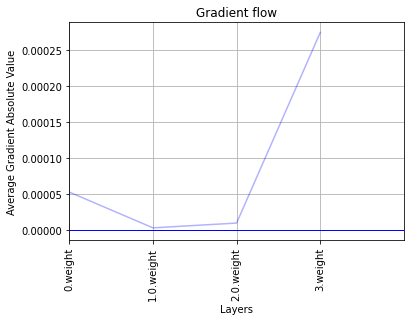

epoch = 0999,  loss =  0.0004868883697781712
training complete


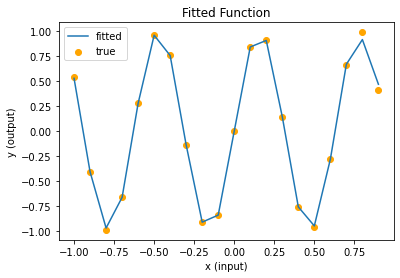

In [45]:
epochs = 1000
torch.manual_seed(0)

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, epochs=epochs, visual_debug=True)


model.eval()
y_pred = model(X_train_aug)

X_train_np = X_train.detach().numpy()
y_train_np = y_train.detach().numpy().reshape(-1)
y_pred_np = y_pred.detach().numpy()
# print(y_pred.shape)

plt.scatter(X_train_np, y_train_np, label="true", c="orange")
plt.plot(X_train_np, y_pred_np, label="fitted")

plt.title("Fitted Function")
plt.xlabel("x (input)")
plt.ylabel("y (output)")
plt.legend()

plt.show()




Now, please **try different initialization configurations (config 1 - 5 )** in the code cells above and **compare the results** of each configuration. Try to **analyze the results with the gradient flow plot**.

### start d

<font color='blue'>

- For config 1, zero initialized weights will cause gradient be 0. That is terrible.

- For config 2, sigmoid activation function with small initialization variance can give us a solution that is not too absurd. the gradients are not zero and the neural network are trying to learn something. But from the parameters we can see that the represetation power of this neural network is very limited.

- For config 3, we try to increase the capacity of the neural neural by increasing numbers of neurons for each layer. And the result is much better now.

- For config 4, we want to increase the capacity of the neural network further by increasing the layers. Supposely, it will perform better. But unfortunatetely, there is a gradient vanishing! Now the output is zero.

- for config 5, from the gradient plot we can find that an inappropriate initialization can also cause gradient vanishing!

</font>


### end d


## (e) Xavier initialization - theory

Please check the assignment document and derive the formula of Xavier initialization. We will use it in the next part.

## (f) Xavier initialization - practice

Please **implement Xavier initialization** in the following codes. **You can only use NumPy**, although our codes will convert your results into PyTorch tensors later.

In [46]:
#  Xavier for normal distribution
def init_xavier_normal(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ### TODO: your codes here
    ### start f-1
    sigma = np.sqrt(2.0 / float(w.shape[0] + w.shape[1]))
    result = sigma * np.random.randn(*(w.shape))
    ### end f-1
    return(result)

#  Xavier for normal distribution
def init_xavier_uniform(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ### TODO: your codes here
    ### start f-2
    d = np.sqrt(6.0 / float(w.shape[0] + w.shape[1]))
    result = np.random.uniform(-d, d, w.shape)
    ### end f-2
    return(result)


## (h) Kaiming initialization - theory

Please check the assignment document and derive the formula of Kaiming initialization. We will use it in the next part.

## (i) Kaiming initialization - practice

Please **implement Kaiming initialization** in the following codes. **You can only use NumPy**, although our codes will convert your results into PyTorch tensors later.

In [47]:
#  Kaiming for normal distribution
def init_kaiming_normal(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ### TODO: your codes here
    ### start i-1
    sigma = np.sqrt(2.0 / float(w.shape[0] + w.shape[1]))
    result = sigma * np.random.randn(*(w.shape))
    ### end i-1
    return(result)


#  Kaiming for normal distribution
def init_kaiming_uniform(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ### TODO: your codes here
    ### start i-2
    d = np.sqrt(12.0 / float(w.shape[0] + w.shape[1]))
    result = np.random.uniform(-d, d, w.shape)
    ### end i-2
    return(result)

## (j) Put them all together

epoch = 0049,  loss =  0.4770474433898926
training complete
epoch = 0049,  loss =  0.5030922889709473
training complete
epoch = 0049,  loss =  0.5734130144119263
training complete
epoch = 0049,  loss =  0.5024377107620239
training complete


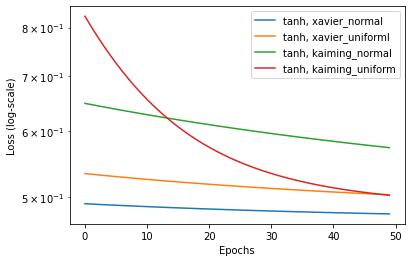

In [48]:
torch.manual_seed(0)
epochs = 50
log_interval = epochs
optimizer = "sgd"

### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="xavier_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, xavier_normal")


### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="xavier_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, xavier_uniforml")


### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="kaiming_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, kaiming_normal")


### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="kaiming_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, kaiming_uniform")

plt.xlabel("Epochs")
plt.ylabel("Loss (log-scale)")
plt.yscale("log")
plt.legend()
plt.show()


The above codes will train the same neural network with tanh activation using different initialization methods. **Run the above codes and write your obeservation** here.

### start j-1

<font color='blue'>

For our model with tanh activation, using xavier_normal performs better than xavier_uniform, kaiming uniform and kaiming_normal.

The result is consistent with the assumption for Xavier initialization. Tanh satisfies the assumption in derivating Xavier initialization while it doesn't satify Kaiming initialization's assumption.


</font>

### end j-1


epoch = 0049,  loss =  0.49839457869529724
training complete
epoch = 0049,  loss =  0.5135116577148438
training complete
epoch = 0049,  loss =  0.49252113699913025
training complete
epoch = 0049,  loss =  0.45879799127578735
training complete


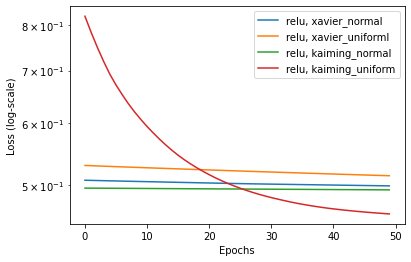

In [49]:
torch.manual_seed(0)
epochs = 50
log_interval = epochs
optimizer = "sgd"

### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="xavier_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, xavier_normal")


### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="xavier_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, xavier_uniforml")


### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="kaiming_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, kaiming_normal")


### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="kaiming_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, kaiming_uniform")

plt.xlabel("Epochs")
plt.ylabel("Loss (log-scale)")
plt.yscale("log")
plt.legend()
plt.show()


The above codes will train the same neural network with tanh activation using different initialization methods. **Run the above codes and write your obeservation** here.

### start j-2

<font color='blue'>

For our model with ReLU activation, using kaiming_normal performs better than xavier_uniform, xavier_normal and kaiming uniform.

The result is consistent with the assumption for Kaiming initialization. ReLU satisfies the assumption in derivating Kaiming initialization while it doesn't satify Xavier initialization's assumption.


</font>

### end j-2